# Sparse Coding of Natural Images and Digits

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark import SparkContext, SparkConf

import string
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

#import data from json file
spark = SparkSession.builder.master('local[50]').appName("sparsecoding").getOrCreate()
#df = spark.read.json("/project/cmsc25025/mnist/data.json")

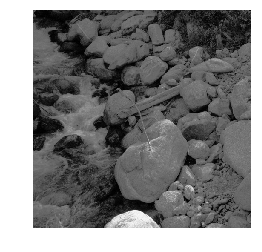

In [2]:
import scipy.io
data = scipy.io.loadmat('/project/cmsc25025/sparsecoding/IMAGES_RAW.mat')

images = data['IMAGESr']

# images is a 3D array of size [512,512,10]
# where the 10 images are of size 512 x 512

import matplotlib.pyplot as plt
plt.imshow(images[:,:,1], cmap='gray')
plt.axis('off')
plt.show()

In [3]:
images[:,:,1].shape

(512, 512)

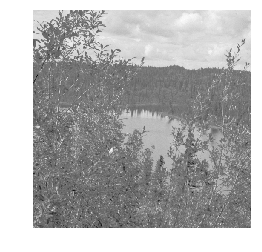

In [4]:
plt.imshow(images[:,:,3], cmap='gray')
plt.axis('off')
plt.show()

# Part 1: Sparse Coding of Natural Images

Sample Patches

In [3]:
import random
import numpy as np

def sample_patches(image, num, width):
    patches = np.zeros([num, width**2])
    for k in range(num):
        i, j = random.sample(range(image.shape[0] - width), 2)
        patches[k] = np.reshape(image[i:i+width, j:j+width], (width**2,))
    return patches

def sample_all(images, n_images, n_sample, width):
    s = []
    for i in range(0, n_images):
        patches = sample_patches(images[:, :, i], n_sample / n_images, width)
        s.append(patches)
    s = np.vstack((s[i] for i in range (0, n_images)))
    return s

# Sparse Coding

In [4]:
def max_component_ind(r,x): 
    '''
    r :: residual, n*1
    x :: basis vectors, p**n
    '''
    
    projection = np.dot(r.T, x.T)
    norm = np.linalg.norm(x, axis=1)
    norm[norm==0.0] = 1.
    a = projection/norm
    j = np.argmax(np.abs(a))
    return j

def omp(y,cb,k):
    r = y
    s = []
    orth = np.copy(cb)
    x_zero = np.zeros(len(y))
    beta = np.zeros(len(cb))
    for i in range (0,k):
        orth[s] = x_zero
        j = max_component_ind(r,orth)
        s.append(j)
        Xs =cb[s]
        b_hat = np.linalg.inv(Xs.dot(Xs.T)).dot(Xs).dot(y)
        for x in s:
            beta[x] = b_hat[s.index(x)]
        r = r-beta.dot(cb)
    return beta

def sgd(codebook,step,y,beta):
    norm = np.linalg.norm(codebook, axis=1)
    norm[norm<1.]=1.
    grad = (codebook.T.dot(beta.T)-y.T).dot(beta)
    new_cb = codebook-step*grad.T
    return new_cb

def plot_codebook(cb,size):
    idx = np.random.randint(200, size=18)
    s = cb[idx,:]
    fig, ax = plt.subplots(3,6,figsize=(8,4))
    for i in range (0,3):
        for j in range (0,6):
            ax[i,j].imshow(s[i*6+j].reshape((size,size)), cmap='gray')
    plt.show()

def adj_patches(image, width):
    patches = []
    for i in range(0, 512, width):
        for j in range(0, 512, width):
            patches.append(np.reshape(image[i:i+width, j:j+width], (width**2,)))
    return patches 

In [5]:
#sample images
X = sample_all(images, 10, 200, 8)
Y = sample_all(images, 10, 70000, 8)
patches = sample_all(images,10,5000,8)
patches_rdd = spark.sparkContext.parallelize(patches)
num_codes = 15

At initialization


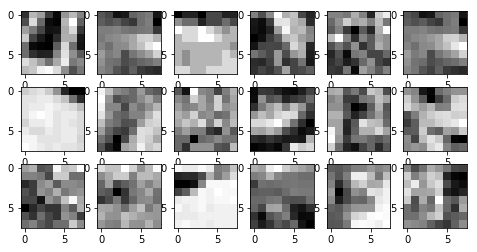

Iteration:  100.0 Error:  0.0569632492111 



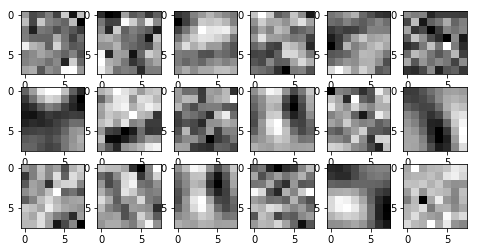

Iteration:  200.0 Error:  0.0552597149915 



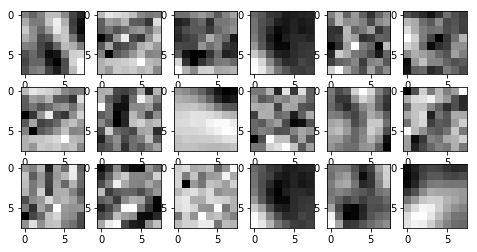

Iteration:  300.0 Error:  0.0545398958916 



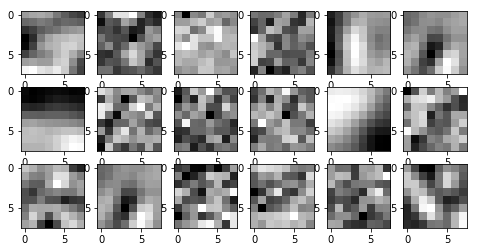

Iteration:  400.0 Error:  0.05440195003 



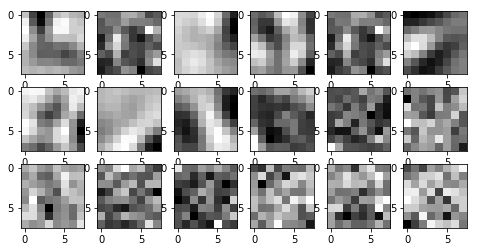

Iteration:  500.0 Error:  0.0539895058807 



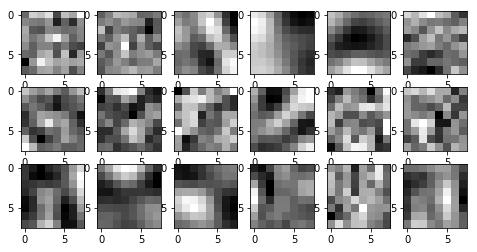

Iteration:  600.0 Error:  0.0539507149243 



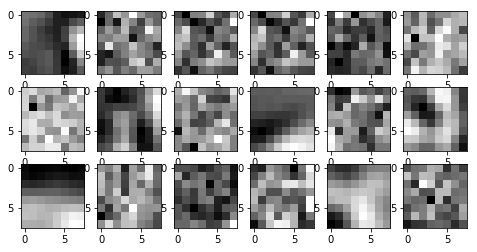

Iteration:  700.0 Error:  0.0534363990675 



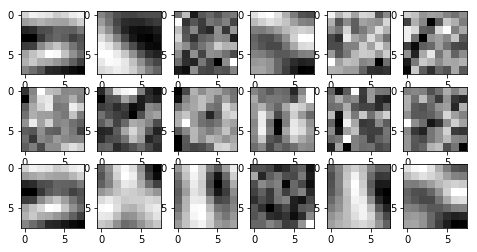

Iteration:  800.0 Error:  0.0533322635318 



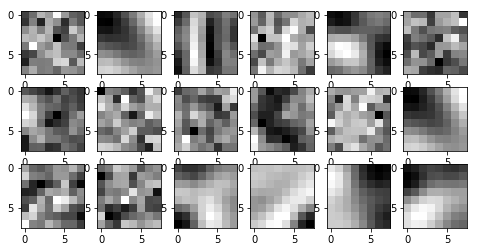

Iteration:  900.0 Error:  0.0532479808625 



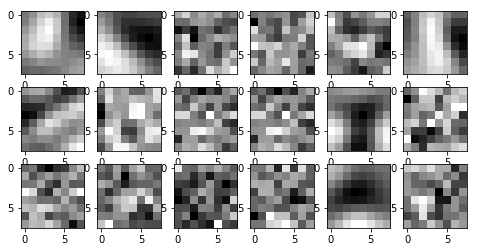

Iteration:  1000.0 Error:  0.0530905654502 



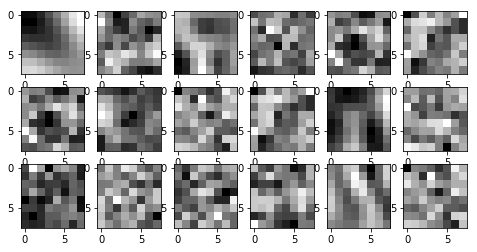

After convergence


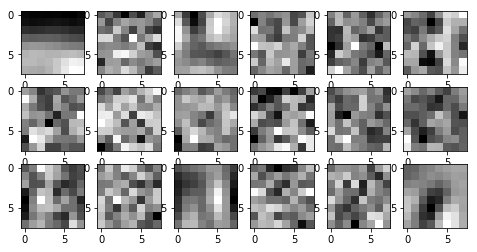

In [6]:
#Find codewords
err = .5
err_prev = 1.
t = 1.

print "At initialization"
plot_codebook(X,8)

while (err>.053 or err<=err_prev):
    ind = np.random.randint(69999, size=2800)
    mini = Y[ind,:]
    mini_rdd = spark.sparkContext.parallelize(mini).cache()
    eta = np.power(t,-0.6)
    beta = mini_rdd.map(lambda x: omp(x,X,num_codes)).collect()
    beta = np.asarray(beta)
    X = sgd(X,eta,mini,beta)
    beta_valid = patches_rdd.map(lambda x: omp(x,X,num_codes)).collect()
    beta_valid = np.asarray(beta_valid)
    residual = patches - beta_valid.dot(X)
    err_prev = err
    err = np.mean(residual**2)
    t+=1.
    if int(t)%100==0:
        print 'Iteration: ',t,'Error: ',err,'\n'
        plot_codebook(X,8)

print "After convergence"
plot_codebook(X,8)

In [7]:
print "It takes about 1000 steps to converge. The codewords gradually bear more resemblance with Gabor waves, as the codebook approaches convergence"

The codewords gradually bear more resemblance with Gabor waves, as the codebook approaches convergence


(64,)
(64,)


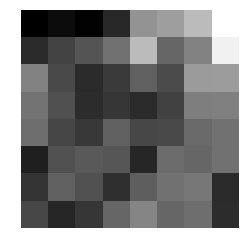

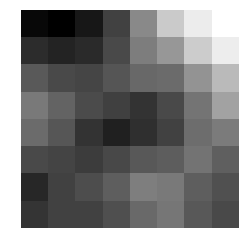

In [8]:
patch = patches[1]
reconstruction = beta_valid[1].dot(X)

print patch.shape
print reconstruction.shape

plt.imshow(patch.reshape(8,8), cmap='gray')
plt.axis('off')
plt.show()

plt.imshow(reconstruction.reshape(8,8), cmap='gray')
plt.axis('off')
plt.show()

# Part 2: Sparse Coding of MNIST

In [5]:
df = spark.read.json("/project/cmsc25025/mnist/data.json")
count = df.count()
X2 = df.rdd.map(lambda x: np.asarray(x['features']))\
                                            .sample(False,200.0/float(count), seed=123).collect()
X2 = np.asarray(X2)

Y2 = df.rdd.map(lambda x: np.asarray(x['features']))\
            .sample(False,30000.0/float(count), seed=123).collect()
Y2 = np.asarray(Y2)

valid_rdd2 = df.rdd.map(lambda x: np.asarray(x['features']))\
            .sample(False,500.0/float(count), seed=123).cache()
Y_valid2 = np.asarray(valid_rdd2.collect())

At initialization


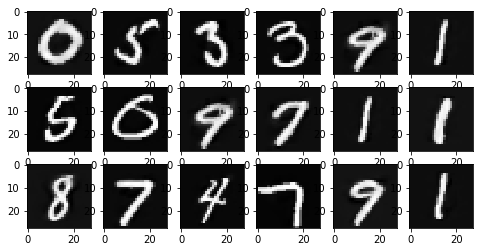

0.0151209386914


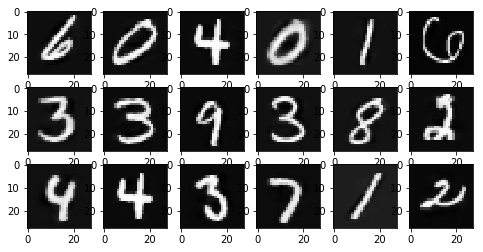

0.0150752338338


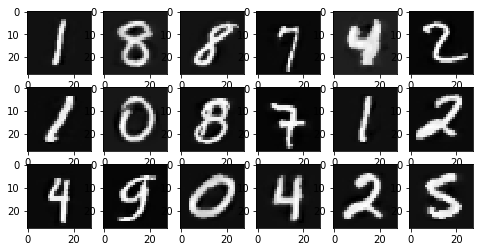

0.0150140623428


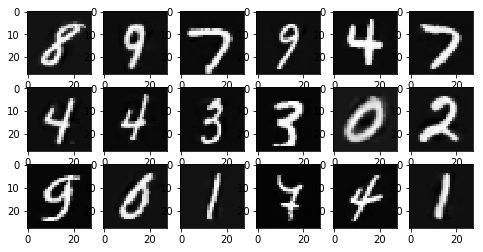

0.0149788327839


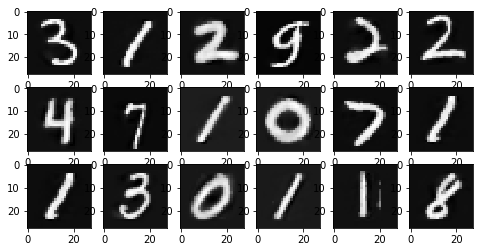

After convergence


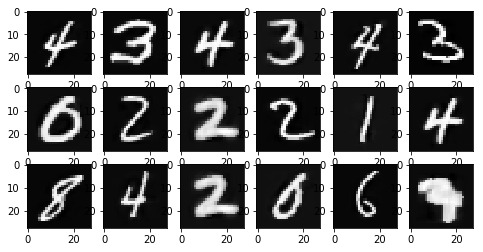

In [10]:
err = .5
err_prev2 = 1.
t = 1.
K2 = 10
print "At initialization"
plot_codebook(X2,28)

while (err >.015 or err <=err_prev):
    n = len(Y_valid2)
    eta = np.power(t,-0.6)/200
    ind = np.random.randint(29897, size=280)
    mini = Y2[ind,:]
    mini_rdd = spark.sparkContext.parallelize(mini).cache()
    beta = mini_rdd.map(lambda x: omp(x,X2,K2)).collect()
    beta = np.asarray(beta)
    X2 = sgd(X2,eta,mini,beta)
    beta_valid = valid_rdd2.map(lambda x: omp(x,X2,K2)).collect()
    beta_valid = np.asarray(beta_valid)
    residual = Y_valid2-beta_valid.dot(X2)
    err_prev = err
    err = np.mean(residual**2)
    t+=1.
    if int(t)%50==0:
        print err
        plot_codebook(X2,28)

print "After convergence"
plot_codebook(X2,28)

In [8]:
print "The codewords represent all the variety that the image could be like"
print "The results we get is more straightforward and slightly better than PCA"
print "While principal component analysis tries to identify the vectors that have the most variance,"
print "the codewords capture the characteristics of the images by identifying the ones that represent different varieties of the images."

The codewords represent all the variety that the image could be like
The results we get is more straightforward and slightly better than PCA
While principal component analysis tries to identify the vectors that have the most variance,
the codewords capture the characteristics of the images by identifying the ones that represent different varieties of the images.
